# Why you should use Kriging

In this notebook, I will try to present various spatial estimation methods in multi-dimensions (here, for graphical needs, in dimension 2). My goal is to illustrate clearly how each works, his advantages and disadvantages. Lastly, I will present a method that I like very much : Kriging.

Note : this notebooks skips the entire theory behind each method. If you are curious, feel free to do some additional research.

I am trying to rely as few as possible on fancy packages, whose underlying code I am not sure of. Here are the tools you will need, which are some very common and widely used packages.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern #,DotProduct, WhiteKernel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import interp2d, interp1d

## Introduction

Suppose we have a 3D surface with the following equation :

In [28]:
def branin(x,y,a=1,b=5.1/(4*np.pi**2),c=5/np.pi,r=6,s=10,t=1/(8*np.pi)):
    return a*(y-b*x**2+c*x-r)**2+s*(1-t)*np.cos(x)+s

Some of you who have read a bit about optimization (https://en.wikipedia.org/wiki/Test_functions_for_optimization) will recognize it as the Branin function. It is commonly used, as many other functions, to test some optimization algorithms, since it is very strangely shaped with a lot of local minima everywhere, and three global minima (http://www.sfu.ca/~ssurjano/branin.html).

Let's plot it to get a better idea. Please note that, throughout all this notebook, everytime I want to plot something I use the scatter function *on purpose*. This is because with continuous plotting, matplotlib *interpolates* between your points, and since we are trying to study different estimation methods, that would be very untrustworthy. However, if you put enough points, it will always appear to be continuous to the viewer, so that is not a problem.

In [31]:
X=np.linspace(-5,10,1500)
Y=np.linspace(0,15,1500)
points=[(x,y) for y in Y for x in X]

In [32]:
Z=[branin(x,y) for (x,y) in points]
m=max(Z)
colors=cm.rainbow([z/m for z in Z])

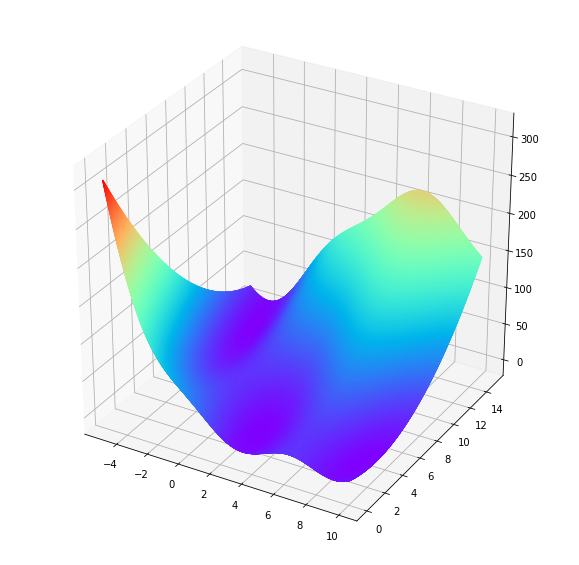

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points],Z, zdir='z', s=0.1, c=colors, depthshade=True)

Now, we will try various interpolation methods, to see which ones seem to approximate this function to the best. Let's randomly sample 100 points from our calculated points, and use them for fitting our interpolation. then we will try to recalculate all the others, and plot them.

In [63]:
coordinates=[(x,y,z) for x,y,z in zip([p[0] for p in points],[p[1] for p in points],Z)]
init_points=np.random.choice(len(coordinates),100)
X,y=np.asarray([points[i] for i in init_points]),[Z[i] for i in init_points]
X_test,y_test=np.asarray([points[i] for i in range(len(coordinates)) if i not in init_points]),[Z[i] for i in range(len(coordinates)) if i not in init_points]
# small=np.random.choice([i for i in range(len(coordinates)) if i not in init_points],100)
# X_test_small,y_test_small=np.asarray([points[i] for i in small]),[Z[i] for i in small]

Throughout this notebook, in addition to the graphics, we will need a suitable metrics to compare the different methods (that is to say, the "error" of each one with respect to the true values). Thereare a lot of possible metrics. I will choose the average mean squared error :

In [43]:
def mse(true,estim):
    loss=0
    for t,e in zip(true,estim):
        loss+=(t-e)**2
    loss=loss/len(true)
    return loss

We will also keep a dictionnary of the calculated errors, that will be useful for future comparisons.

In [66]:
dic_errors={'branin':0}

## Classical interpolation methods

### Linear interpolation

Let's start with the simplest of all methods : linear interpolation. It is very straightforward to implement using scipy (see here : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html).

In [64]:
def interpol_2d(kind,X=X,y=y):
    fun=interp2d([x[0]for x in X],[x[1] for x in X],y,kind=kind)
    return fun

In [65]:
linear=interpol_2d('linear')
Z_linear=[linear(x[0],x[1]) for x in X_test[::2]]
Z_linear=np.concatenate(Z_linear)

C:\Users\lsfer\Anaconda3\envs\maps\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,13 m=100 fp=0.278070 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


What is the error of this method ?

In [67]:
dic_errors['linear']=mse(Z_linear,y_test[::2])
dic_errors

{'branin': 0, 'linear': 29146924743.02073}

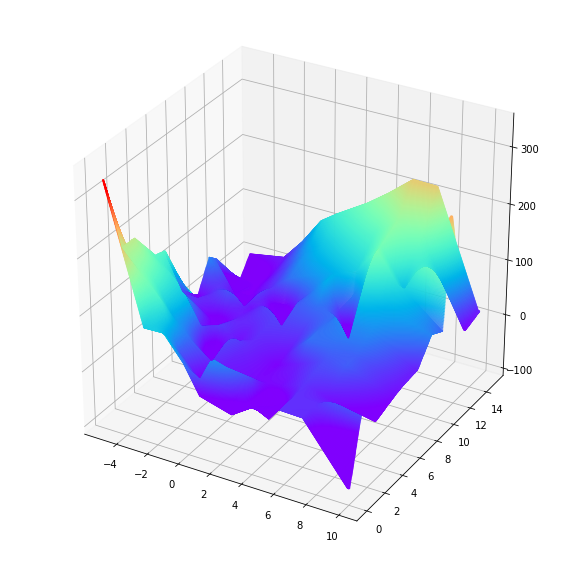

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_linear])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_linear, zdir='z', s=0.1, c=colors, depthshade=True)

We notice very well the "straightness" of linear interpolation : we can easily figure out where were the original points, and the curve is anything but smooth. Notice a big problem in this representation : we have some "layers", on top of each other, instead of a continuous surface (for example right corner).That is because we are plotting a lot of points, and sometimes the model doesn't choose well between which known points to interpolate. We will see int he second part of this notebook that, when you use less points, you don't meet this problem and the result is actually better. Anyway, it doesn't seem, in our case, a very appropriate interpolation method.

### Polynomial interpolation

A spline is a special function defined piecewise by polynomials. In interpolating problems, spline interpolation is often preferred to polynomial interpolation because it yields similar results, even when using low degree polynomials (from https://en.wikipedia.org/wiki/Spline_(mathematics)).

There are so many different types of polynomial interpolation that I will restrict myself to cubic splines (every piece is a polynomial of degree $\leq 3$).

In [68]:
cubic=interpol_2d('cubic')
Z_cubic=[cubic(x[0],x[1]) for x in X_test[::2]]
Z_cubic=np.concatenate(Z_cubic)
dic_errors['cubic_splines']=mse(Z_cubic,y_test[::2])
dic_errors

{'branin': 0, 'linear': 29146924743.02073, 'cubic_splines': 16916.432213250373}

Oh oh... Why is this error so small compared to the linear error ? Let's take a look...

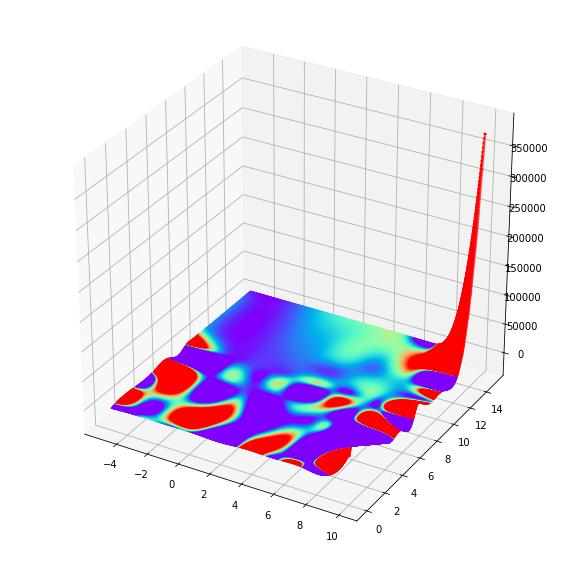

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_cubic])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_cubic, zdir='z', s=0.1, c=colors, depthshade=True)

Oh oh... What happened here ? Well, actually, this is a classical problem of polynomial interpolation (especially with a high degree, like cubic splines) : it explodes at the edges. If we set a maximum $z$ limit, we will see better :

(0, 300)

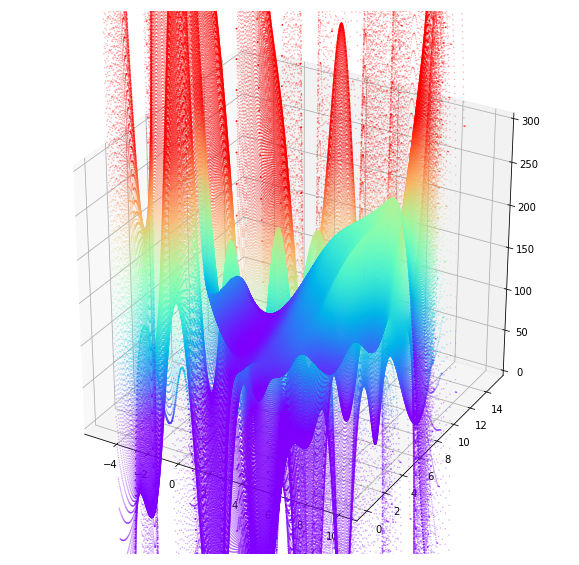

In [38]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_cubic])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_cubic, zdir='z', s=0.1, c=colors, depthshade=True)
ax.set_zlim(0, 300)

Oh oh... Definitely not a good idea, those splines. What is impressive when you think twice about it, is that the squared error on points at the edges must be MASSIVE. Yet it is still more than 1 million times lower than the linear mean squared error ! This means to things : first, in the center of the cube, the spline estimation must not be so bad. Second, linear estimation IS really bad. 

## Other methods

Here I present 2 methods who are not strictly speaking interpolation methods, but still widely used for space estimation.

### K-nearest-neighbors

I encourage you to test different values of n_neighbors, to see the difference in results. However, the conclusion remaines the same.

In [69]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)
Z_knn=neigh.predict(X_test[::2])
dic_errors['knn'] = mse(Z_knn,y_test[::2])
dic_errors

{'branin': 0,
 'linear': 29146924743.02073,
 'cubic_splines': 16916.432213250373,
 'knn': 254.25992244011863}

Wow, a lot better ! Let's take a look.

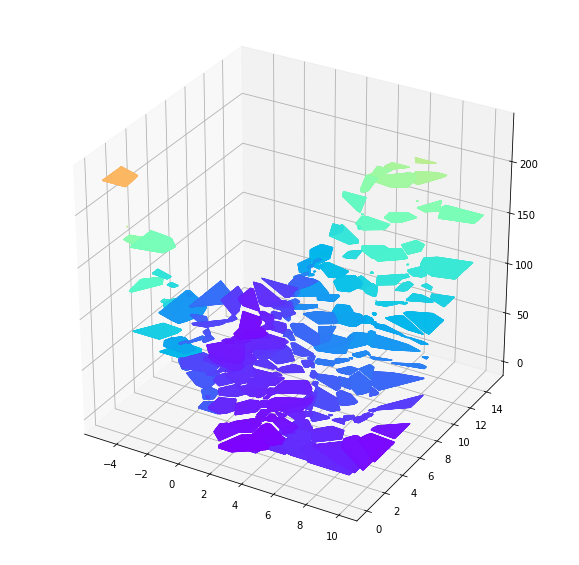

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_knn])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_knn, zdir='z', s=0.1, c=colors, depthshade=True)

We see here very well the fundamental property of k-nn : you can only take 100 Z-values, the ones from the initial points. You cannot get a continuous prediction. We very clearly see the patches surrounding the 100 original points, into which the data is approximated by the value at the central point.

### Random Forest Regression

Here as well, you can try various values for the number of trees, the maximal depth, or the metric.

In [70]:
regr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=100, random_state=0)
regr.fit(X, y)
Z_randforest=regr.predict(X_test[::2])
dic_errors['random_forest'] = mse(Z_randforest,y_test[::2])
dic_errors

{'branin': 0,
 'linear': 29146924743.02073,
 'cubic_splines': 16916.432213250373,
 'knn': 254.25992244011863,
 'random_forest': 534.9248055956306}

Not as good as k-nn, but still a lot better than linear and splines interpolation.

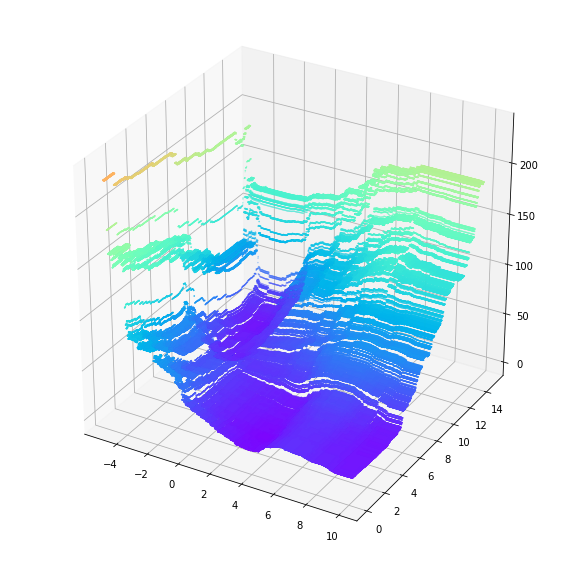

In [40]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_randforest])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_randforest, zdir='z', s=0.1, c=colors, depthshade=True)

Interestingly, we notice here a property of trees : we can see the presence of kind of strays, which are in fact linked to tree branches used in the attribution of value. They define "ranges" of values into which the attributed target is constant.

## Kriging

Here at last, I come to the most interesting part of this notebook ! For those of you who never heard about kriging, I recommend you to start with some theory.

Kriging is a very interesting and powerful interpolation methods, that can be used for various purposes : interpolation, smoothing (like presented here), but also in sequential experiments, in contexts of fixed calculation budgets (more detailed notebook on this subject coming soon), since it presents the advantage to estimate its own standard error in every point of space.

Useful links :

https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process

https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

I you didn't know (I didn't until quite recently), in lots of packages Kriging is actually called Gaussian Process Regressor.

In [73]:
kernel=Matern(length_scale=1,nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X, y)
print(gpr.score(X, y))

1.0


We get a score of 1, which is natural : kriging is an exact interpolation method. Like previously, I encourage you to try different kernels to see the results. There is not one perfect kernel for every function : the choice of kernel depends on what you are trying to estimate.

In [72]:
Z_krig=gpr.predict(X_test[::2], return_std=False)
dic_errors['kriging'] = mse(Z_krig,y_test[::2])
dic_errors

{'branin': 0,
 'linear': 29146924743.02073,
 'cubic_splines': 16916.432213250373,
 'knn': 254.25992244011863,
 'random_forest': 534.9248055956306,
 'kriging': 55.812670588177795}

Wow, great ! that's the model with the lowest error so far ! And by far !

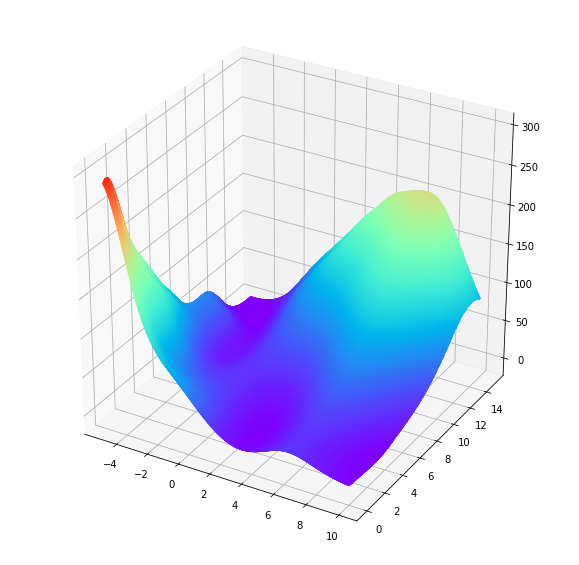

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_krig])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_krig, zdir='z', s=0.1, c=colors, depthshade=True)

Wow, so beautiful, so smooth ! And definitely much alike the original function. However, if you watch carefully, you can still notice areas where it is not very well estimated (for example the back corner). It still seems to be, by far, the best method so far.

 Let's take advantage of the kriging property of giving access to error, to see in which area the estimation is poorer :

In [54]:
Z_error=gpr.predict(X_test[::2], return_std=True)

In [55]:
Z_error=Z_error[1]

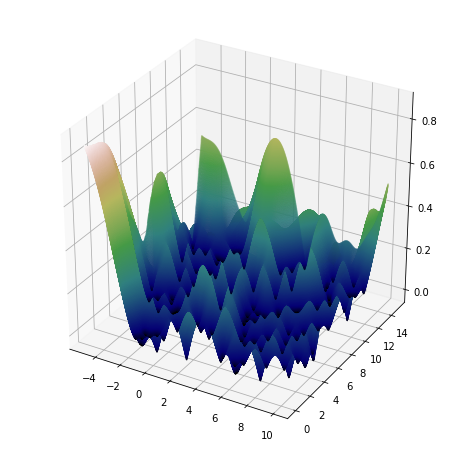

In [57]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
mm=max(Z_error)
colors=cm.gist_earth([z/mm for z in Z_error])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_error, zdir='z', s=0.1, c=colors, depthshade=True)

Like expected, the loss is particularly high in the back corner, but globally when you look at its range of values, it stays rather low compared to other methods.

## Conclusion

I don't want you to conclude from this notebook that you should always use Kriging, and that the other methods never work. Actually, there isn't one perfect method for every estimation problem. Please note that the function I have chosen, the Branin function, is a very peculiar function, often studied for its uncommon properties, that was a perfect example for this notebook. But on most simpler functions, the other methods can work as well, and sometimes even better than Kriging !

# Sequential Kriging

Let's now take advantage of a fundamental property of Kriging : getting access to the model error (std to 95%). This comes from the fact that Gaussian Process Regression is a *probabilitic method*, originally used to estimate some well behaved random variables.

## Introduction

The context is the following : suppose we have a model we try to estimate by Kriging. However, an exact simulation of the value of a point is costly (in money, in case of physical experiences, or in time, in case of computing). For simplicity, we will keep the Branin function in this part.

The question is : how can you spend your fixed budget of simulations (let's say *100*, like we did previously) in the most intelligent way possible, that is to say, resulting in the best estimation possible of your model ? We will study and compare two strategies : sampling all the 100 points from the beginning and spending it all in one-shot, and spending them one point after another, carefully choosing the next point to simulate based on your most recent estimate of your model.

Let us keep track of errors :

In [74]:
dic_errors_montecarlo=dic_errors
dic_errors_grid={'branin' : 0}

### One-shot strategy

If you want to choose all your points from the beginning, you have several strategies available : drawing a grid in your input space to sample your points, or taking them random (there are, of course, several levels of randomness available). I will first present the grid-sampling strategy and explain why it is a bad idea, then go to the random sampling strategies.

#### Grid-sampling

Let's just suppose for a moment that, instead of our Branin function, we are trying to estimate the following function :

In [2]:
def ackley(x,y=0):
    return -20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + np.exp(1) + 20

Some of you might have recognized the 2D-Ackley function, projected in the plane $y=0$. Let's plot it to get a quick idea.

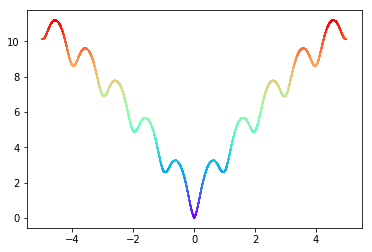

In [8]:
ackley_x=np.linspace(-5,5,100000)
ackley_y=[ackley(x) for x in ackley_x]
ackley_m=max(ackley_y)
colors=cm.rainbow([y/ackley_m for y in ackley_y])
plt.scatter(ackley_x,ackley_y,s=0.1,c=colors)

Now, let's suppose that we want to estimate this function with a regular grid between -5 and 5, of step 1.

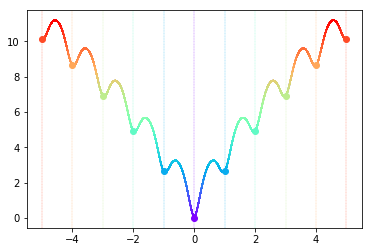

In [18]:
ackley_grid_x=np.linspace(-5,5,11)
ackley_grid_y=[ackley(x) for x in ackley_grid_x]
colors_2=cm.rainbow([y/ackley_m for y in ackley_grid_y])
plt.scatter(ackley_x,ackley_y,s=0.1,c=colors)
for x,y,c in zip(ackley_grid_x,ackley_grid_y,colors_2):
    plt.axvline(x=x,linestyle='--',linewidth=0.3,c=c)
#     plt.axhline(y=y,linestyle='--',linewidth=0.3,c=c)
    plt.plot(x,y,'o',c=c)

On this base, looking at the sampled points, anyone would easily do a simple linear or polynomial interpolation to estimate this model, and feel quite confident about it, whereas he is actually missing a lot of information about the true model.

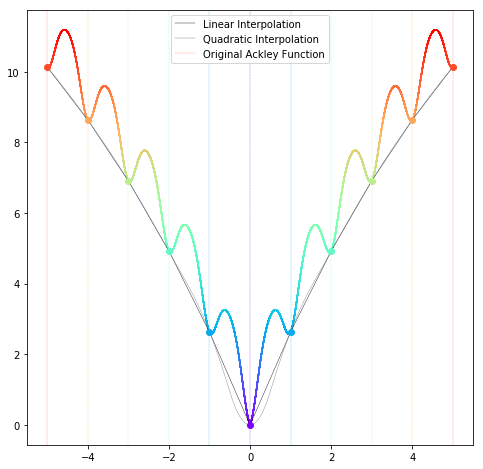

In [25]:
ackley_interp_linear=[interp1d(ackley_grid_x,ackley_grid_y,kind='linear')(x) for x in ackley_x]
ackley_interp_quadratic=[interp1d(ackley_grid_x,ackley_grid_y,kind='quadratic')(x) for x in ackley_x]
labels=['Linear Interpolation','Quadratic Interpolation','Original Ackley Function']
plt.figure(figsize=(8,8))
plt.scatter(ackley_x,ackley_y,s=0.1,c=colors)
plt.plot(ackley_x,ackley_interp_linear,'k',linewidth=0.4)
plt.plot(ackley_x,ackley_interp_quadratic,'slategray',linewidth=0.4)
for x,c in zip(ackley_grid,colors_2):
    plt.axvline(x=x,linestyle='--',linewidth=0.3,c=c)
    plt.plot(x,ackley(x),'o',c=c)
plt.legend(labels)

This example helps me come to my point : with a regular grid, you often (not to say always) lose a loooot of information about your function. Only a random sampling can help you capture a better idea of the real behaviour of your function. To sums things up, you should never, ever, use a regular grid to estimate a function you are not sure of (or at least, you should always add random points in addition to the regular grid).

Now let's come back to our 2D-Branin function. What happens if we estimate it using a 100-points-regular-grid ? Let's do just a simple linear interpolation first :

In [29]:
grid_x=np.linspace(-5,10,10)
grid_y=np.linspace(0,15,10)
points_grid = [(x,y) for x in grid_x for y in grid_y]
branin_grid=[branin(x,y) for x in grid_x for y in grid_y]

In [61]:
linear=interpol_2d('linear',X=points_grid,y=branin_grid)
Z_linear=[linear(x[0],x[1]) for x in X_test[::2]]
Z_linear=np.concatenate(Z_linear)
dic_errors_grid['linear'] = mse(Z_linear,y_test[::2])
dic_errors_grid

{'branin': 0, 'linear': 10.210048989922567}

Funny, the linear model seems to work better on a regular grid than on random points !

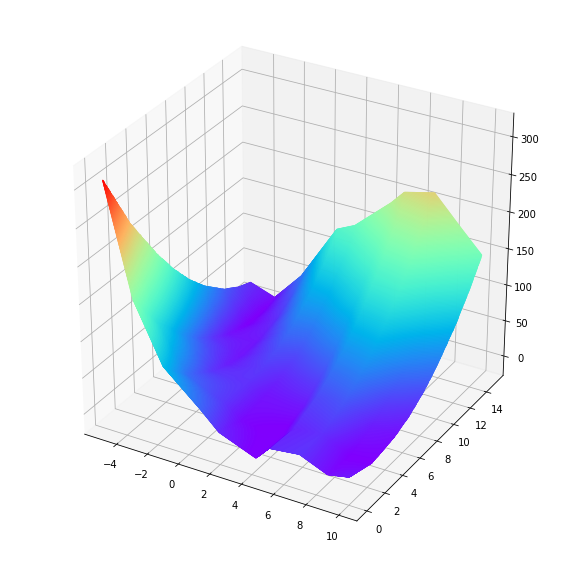

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_linear])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_linear, zdir='z', s=0.1, c=colors, depthshade=True)

Well, not so bad ! But it still lacks some smoothness. Looking at the edges of the surface, we can easily guess where the grid lines here (angles). Now trying with Kriging :

In [62]:
kernel=Matern(length_scale=1,nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(points_grid, branin_grid)
krig=gpr.predict(X_test[::2], return_std=True)
Z_krig,Z_error=krig[0],krig[1]
dic_errors_grid['kriging'] = mse(Z_krig,y_test[::2])
dic_errors_grid

{'branin': 0, 'linear': 10.210048989922567, 'kriging': 9.483223967163205}

Kriging also seems to work better on a regular grid. It is still better than the linear model.

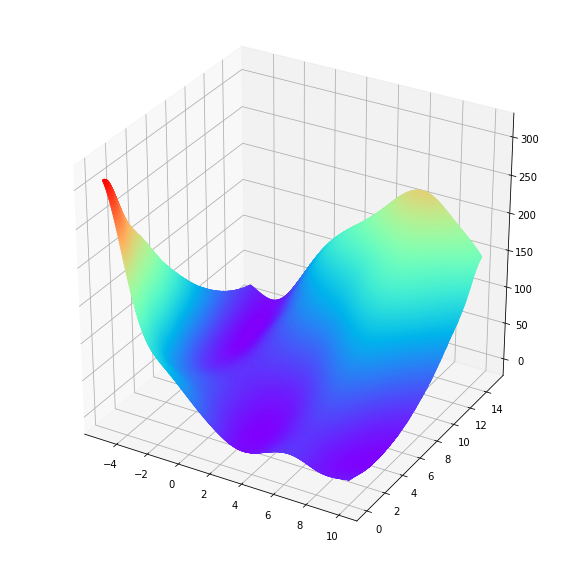

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
colors=cm.rainbow([z/m for z in Z_krig])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_krig, zdir='z', s=0.1, c=colors, depthshade=True)

Better than with linear interpolation... Let's now take a look at the error :

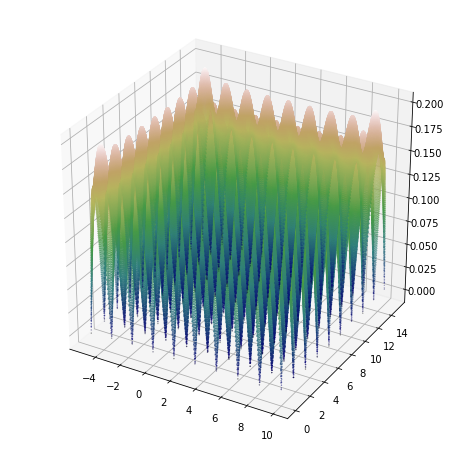

In [42]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
max_error=max(Z_error)
colors=cm.gist_earth([z/max_error for z in Z_error])
ax.scatter([x[0] for x in X_test[::2]],[x[1] for x in X_test[::2]],Z_error, zdir='z', s=0.1, c=colors, depthshade=True)

The error is very symetrical, contrary to the previous one we had on random points.